# Assignment 3: Classification

**Deadline**: 28 April 2025

**Packages**: NumPy, Pandas, Scikit-learn

**Name**: Sergey Bororndzhiyan

**Matriculation Number**: K12353745

**Submission Instructions**: Upload your Jupyter notebook and a PDF export (with results) on Moodle. Furthermore, upload the exported KNIME workflow (with your pickle file in the data directory) for Task 1.4 on Moodle. Go to the corresponding checkmark list to indicate which tasks you have completed and feel confident to explain in class. The checkmark list will be the basis for grading. If you fail to explain your submission you will be awarded 0 points for the entire assignment; after the second such incident you would fail the course.

Write your solutions in the code cells for the different tasks. You may also add additional code cells as well as markdown cells if you want to write down additional explanations, observations, or assumptions.

There are also questions that require you to write textual answers into markdown cells.

**If anything is unclear, ask in the forum on Moodle and/or make reasonable assumptions. Document any such assumptions in the Jupyter notebook and the PDF report.**



## Case 1: Bank Loans

**Files**: loans.csv

You have a dataset of loan documentation. The goal is to train a model that will predict whether a loan is good or bad based on various indicators.

### Task 1.1: Data Preprocessing

Our analysis will require a class variable to distinguish good loans from bad loans. We can derive that from the detailed loan status described by the *loan_status* variable. Add a variable *class*, derived from *loan_status* as follows:

* Assign *class* to 'good' if *loan_status* is 'Fully Paid' or 'Does not meet the credit policy. Status:Fully Paid'.
* Assign *class* to 'bad' if *loan_status* is 'Default', 'Charged Off', or 'Does not meet the credit policy. Status:Charged Off'.

Our analysis will require that each loan's class is known. Include only inactive loans for which the class is known, which are loans with a *loan_status* value mapped to class 'good' or 'bad'. Other *loan_status* values indicate that a loan is still active.

Our analysis will require variables to be in numerical representation, though the dataset includes potentially useful information in categorical representation. Convert categorical variables to numerical representation as follows:

* From *term*, remove the word 'months'.
* From *emp_length*, remove 'year*', change '< 1' to 0, change '10+' to 10, change 'n/a' to null value.
* Change *grade*, *sub_grade*, *home_ownership*, and *purpose* to numerical values by index coding, i.e., transforming the string categories into numeric values, where each category corresponds to an integer value.

Transform the dataset for analysis. Filter out (i.e., remove) some of the variables like this:

* Identification variables, like *id* and *member_id* are not predictive, so we do not include them.
* Leaky variables are those that contain information that could only be known when the class is already known. Since we are ultimately interested in predicting the class before the class is actually known, we do not include leaky variables *recoveries*, *collection_recovery_fee*, or *collections_12_mths_ex_med*.
* Empty variables, i.e., columns with only null values, are missing any information at all, so we do not include them.
* No-variance variables are missing any information at all, so we do not include them.
* Sparse variables, i.e., those with more than half of their values missing, might be too difficult to sensibly impute, so we do not include them.

For convenience, do not include non-numerical variables, except for the class variable.

Impute by simply substituting zeros for missing values.

Normalize the variables using z-score normalization.

Convert to principal component representation and filter out the low-variance principal components. Ultimately, you should end up with only the first two principal components (and the class).

See https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html for more information on principal component analysis (PCA) using scikit-learn.

The provided KNIME workflow specifies the necessary preprocessing steps. If you double-click on the **Data Cleaning** and **Apply PCA** nodes, you can view the workflow of these components.

['Fully Paid' 'Charged Off' 'Current' 'Default' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']
class
good    49561
bad     10274
Name: count, dtype: int64
Original shape : (59835, 35)
PCA shape      : (59835, 2)

PC   indiv%   cum%
01   24.19%   24.19%
02    9.62%   33.81%


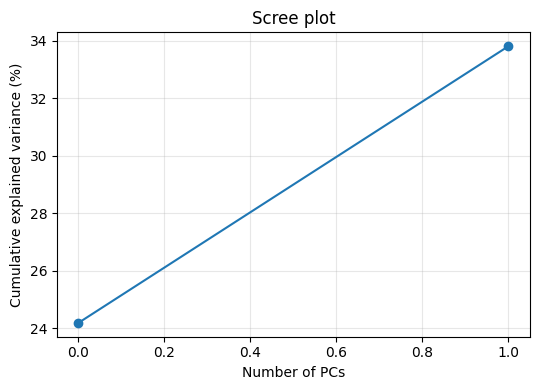

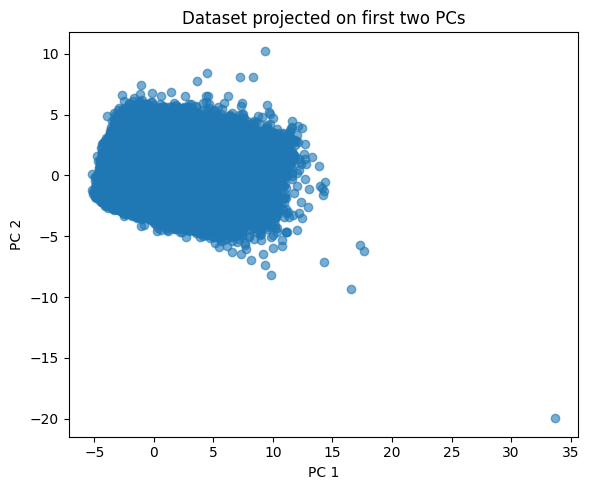

In [48]:
import pandas as pd            #
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

loans_df = pd.read_csv("loans.csv")
#print(loans_df.head())
print(loans_df['loan_status'].unique())

completed_statuses = [
    'Fully Paid',
    'Default',
    'Charged Off',
    'Does not meet the credit policy. Status:Fully Paid',
    'Does not meet the credit policy. Status:Charged Off'
]
loans_df = loans_df[loans_df['loan_status'].isin(completed_statuses)].copy()

conditions = [
    loans_df['loan_status'].isin(['Default', 'Charged Off',
                                  'Does not meet the credit policy. Status:Charged Off']),
    loans_df['loan_status'].isin(['Fully Paid',
                                  'Does not meet the credit policy. Status:Fully Paid'])
]
choices = ['bad', 'good']

# оставляем только неактивные займы, для которых класс известен (то есть class не равен Active)
loans_df['class'] = np.select(conditions, choices, default='active')


loans_df['term'] = loans_df['term'].str.replace('months','',regex=False).str.strip().astype(int)

loans_df['emp_length'] = (loans_df['emp_length']
    .str.lower()
    .str.replace('years?', '', regex=True)
    .str.replace('< 1', '0', regex=False)
    .str.replace('10+', '10', regex=False)
    .str.strip()
    .replace('n/a', np.nan)
    .astype(float)   # или Int64, если хочешь сохранить NaN в int-столбце
)
loans_df['grade'] = pd.Categorical(loans_df['grade']).codes
loans_df['sub_grade'] = pd.Categorical(loans_df['sub_grade']).codes
loans_df['home_ownership']=pd.Categorical(loans_df['home_ownership']).codes
loans_df['purpose']=pd.Categorical(loans_df['purpose']).codes

ident_vars=['id', 'member_id', 'url', 'zip_code'] #Identi􀀂cation variables
loans_df = loans_df.drop(columns=[col for col in ident_vars if col in loans_df.columns])
leaky_vars = ['recoveries', 'collection_recovery_fee','collections_12_mths_ex_med']
# "leaky" переменные, которые содержат информацию, доступную только после определения класса
loans_df=loans_df.drop(columns=[col for col in leaky_vars if col in loans_df.columns])

empty_vars = [col for col in loans_df.columns if loans_df[col].isnull().all()]
loans_df=loans_df.drop(columns=empty_vars)


no_variance_vars = [col for col in loans_df.columns
    if col != 'class' and loans_df[col].nunique(dropna=True) <= 1]
#.nunique() считает количество уникальных значений в колонке, Параметр dropna=True означает: Не учитывать NaN при подсчёте/ Если количество уникальных значений (без учёта NaN) меньше или равно 1 — включаем колонку в список».
loans_df=loans_df.drop(columns=no_variance_vars)

if 'class' in loans_df.columns:
    class_series = loans_df['class']
    # .select_dtypes() в pandas используется для выбора столбцов определённых типов данных
    # include=[np.number] — Выбери все числовые переменные (целые числа и числа с плавающей точкой)»
    data_numeric =  loans_df.select_dtypes(include=[np.number]) #выбираем все числовые переменные
    loans_df = pd.concat([data_numeric, class_series], axis=1)
    #axis=1 - объединение происходит по колонкам (то есть по горизонтали, слева направо).
else:
    loans_df=loans_df.select_dtypes(include=[np.number])

# вставляем нули вместо отстутств значений

loans_df = loans_df.fillna(0)
print(loans_df['class'].value_counts())

#loans_preprocessed=loans_df.to_csv('loans_prepocessed.csv', index=False, encoding='utf-8')
# Разделяем данные на признаки (X) и целевую переменную (y)
# Исключаем столбец 'class' из признаков, так как это наша цель.
X = loans_df.drop(columns=['class'])
y = loans_df['class'] # Class label


# Нормализуем признаки с помощью Z-score zj= xj−μj/ σj
# признаки «сопоставимы» по масштабу (особенно важно для PCA).

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

# Создаём DataFrame с названиями признаков PC1 и PC2
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=X.index)

print(f"Original shape : {X.shape}")      # (n_samples, n_features)
print(f"PCA shape      : {X_pca.shape}")  # (n_samples, 4)

indiv = pca.explained_variance_ratio_
cum = indiv.cumsum()


print("\nPC   indiv%   cum%")
for k, (iv, cv) in enumerate(zip(indiv, cum), start=1):
    print(f"{k:02d}   {iv:6.2%}   {cv:6.2%}")

plt.figure(figsize=(5.5, 4))
plt.plot(cum*100, marker='o')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative explained variance (%)')
plt.grid(alpha=.3)
plt.title('Scree plot')
plt.tight_layout()
plt.show()

# 6) 2‑D scatter of the **first two** PCs (just for visualisation)
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Dataset projected on first two PCs')
plt.tight_layout()
plt.show()


In [49]:
from sklearn.preprocessing import StandardScaler

# X – матрица признаков без целевой переменной (например, loans_df.drop('class', axis=1))
scaler = StandardScaler()
X_z = scaler.fit_transform(X)        # fit = вычислить µ,σ; transform = применить

from sklearn.decomposition import PCA

# 1) сколько компонентов оставить? None → сохраняем ВСЕ
pca = PCA(n_components=None, svd_solver='full')
Z = pca.fit_transform(X_z)

# Доля объяснённой дисперсии по компонентам
explained = pca.explained_variance_ratio_

# Посмотрим распределение дисперсий
for i, var in enumerate(explained, start=1):
    print(f'PC{i}: {var:.3%}')

pca2 = PCA(n_components=2, svd_solver='full')
Z2 = pca2.fit_transform(X_z)            # → shape (n_samples, 2)

# превращаем в DataFrame и подсоединяем метки class
pca_df = pd.DataFrame(Z2, columns=['PC1', 'PC2'], index=X.index)
pca_df['class'] = loans_df['class'].values

pca2 = PCA(n_components=2, svd_solver='full')
Z2 = pca2.fit_transform(X_z)            # → shape (n_samples, 2)

# превращаем в DataFrame и подсоединяем метки class
pca_df = pd.DataFrame(Z2, columns=['PC1', 'PC2'], index=X.index)
pca_df['class'] = loans_df['class'].values

PC1: 24.191%
PC2: 9.622%
PC3: 6.654%
PC4: 5.720%
PC5: 5.169%
PC6: 4.132%
PC7: 3.884%
PC8: 3.630%
PC9: 3.241%
PC10: 3.119%
PC11: 2.964%
PC12: 2.791%
PC13: 2.724%
PC14: 2.613%
PC15: 2.540%
PC16: 2.360%
PC17: 2.107%
PC18: 1.913%
PC19: 1.828%
PC20: 1.762%
PC21: 1.586%
PC22: 1.307%
PC23: 1.188%
PC24: 0.767%
PC25: 0.757%
PC26: 0.493%
PC27: 0.368%
PC28: 0.265%
PC29: 0.159%
PC30: 0.055%
PC31: 0.051%
PC32: 0.023%
PC33: 0.011%
PC34: 0.005%
PC35: 0.000%


### Task 1.2: Classifier Construction

Use the dataset as a k-nearest neighbors (KNN) classifier. Use different values for the hyper-parameter *k*, e.g., three, four, five, and six, to fit a KNN classifier. Use different hyper-parameter values for the construction of the classifier.

You may use the KNIME workflow to obtain the training data if you cannot complete the previous task. To export a CSV file with the preprocessed training data from the KNIME workflow, you have to change the *folder* field in the **Create File/Folder Variables** of the provided KNIME workflow in accordance with your directory hierarchy.

See https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html for k-nearest neighbors in scikit-learn.

In [50]:
from sklearn.neighbors import KNeighborsClassifier # сам алгоритм ближайших соседей
from sklearn.model_selection import  cross_val_score # функция кросс-валидации
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#kодируем метки: 'bad' → 0, 'good' → 1
label_encoder = LabelEncoder()

""" fit(y) «Изучает» список меток y.
Строит словарь соответствий:
сортирует уникальные значения по алфавиту: ['failure', 'ok']
присваивает им номера: 'failure' → 0, 'ok' → 1
transform(y)
Преобразует весь список в список чисел """

y_encoded = label_encoder.fit_transform(y)

#hазбиваем на тренировочную и тестовую выборки
#test_size=0.3 — 30% данных уйдёт в тест
#random_state=42 — фиксируем «семя» для воспроизводимости
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.3,
    random_state=42,# randomise training set, shuffle
    stratify=y_encoded  # сохраним пропорции классов в train/test - 0 and 1 in both classes are the same number
)# stratification
k_values = [3, 4, 5, 6]

best_k = None
best_test_accuracy = 0.0

for k in k_values:
    # Создаём KNN с заданным числом соседей
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #oбучаем на тренировочной выборке
    knn.fit(X_train, y_train)
    
    # предсказания на тестовой выборке
    y_pred = knn.predict(X_test)
    
    #Считаем точность (accuracy) на train и на test
    train_acc = accuracy_score(y_train, knn.predict(X_train))
    test_acc = accuracy_score(y_test, y_pred)
    
    print(f"k = {k}: train accuracy = {train_acc:.4f}, test accuracy = {test_acc:.4f}")
    
    if test_acc > best_test_accuracy:
        best_test_accuracy = test_acc
        best_k = k

# 8. Печатаем оптимальное k по тестовой выборке
print(f"\n Best k = {best_k}, with test accuracy = {best_test_accuracy:.4f}")



k = 3: train accuracy = 0.9741, test accuracy = 0.9572
k = 4: train accuracy = 0.9755, test accuracy = 0.9572
k = 5: train accuracy = 0.9650, test accuracy = 0.9547
k = 6: train accuracy = 0.9679, test accuracy = 0.9560

 Best k = 3, with test accuracy = 0.9572


### Task 1.3: Classifier Evaluation

Conduct five-fold cross-validation to obtain estimates of the performance of the different knn classifiers.

See https://scikit-learn.org/stable/modules/cross_validation.html for more information cross-validation using scikit-learn.

In [51]:
from sklearn.model_selection import cross_val_score, KFold   # Для кросс-валидации
best_k = None
best_score = 0.0
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for k in k_values:
    # Создаём KNN-классификатор с числом соседей = k
    knn = KNeighborsClassifier(n_neighbors=k)
    # Запустим кросс-валидацию и возьмём метрику точности (accuracy)
    scores = cross_val_score(knn, X_pca, y, cv=cv, scoring='accuracy')
    print(f"K={k}, accuracy scores: {scores}, mean accuracy: {scores.mean():.4f}")

    if scores.mean() > best_score:
        best_score = scores.mean()
        best_k = k

# Показываем лучший результат
print(f"\nBest K = {best_k}, with mean accuracy = {best_score:.4f}")


K=3, accuracy scores: [0.79301412 0.78825102 0.78841815 0.79226205 0.78917022], mean accuracy: 0.7902
K=4, accuracy scores: [0.76451909 0.7613437  0.76067519 0.76568898 0.7604245 ], mean accuracy: 0.7625
K=5, accuracy scores: [0.8062171  0.80479652 0.80128687 0.81231721 0.80396089], mean accuracy: 0.8057
K=6, accuracy scores: [0.79426757 0.78774964 0.79084148 0.79627308 0.78917022], mean accuracy: 0.7917

Best K = 5, with mean accuracy = 0.8057


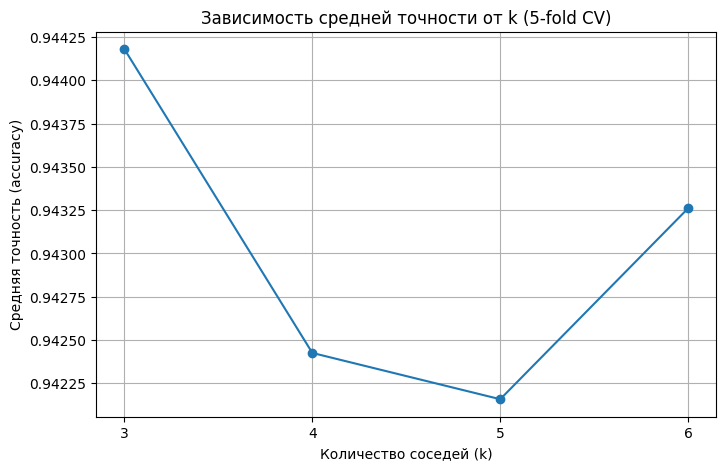

### Task 1.4: Deployment

Export one of the previously constructed classifiers as a **pickle** file named "classifier.pkl".

See https://scikit-learn.org/stable/model_persistence.html for options on model persistence and refer to the pickle module documentation.

Install the **KNIME Python Integration** and **KNIME Conda Integration** (optional, if you use Anaconda/Conda) extensions in KNIME. Integrate the pickle file in the provided KNIME workflow and use your model to classify new observations. Note that you have to load the exported pickle file into the data directory of the KNIME workflow (inside the project's directory in your KNIME workspace).

We will take the loans with unknown class from the original dataset and use the trained model to predict the class. Take a look at the preprocessing steps in the KNIME workflow. Notice that the preprocessing of the "new" data to be classified uses the same models for normalization and PCA than the training data, i.e., we use the normalization model and the PCA weight matrix obtained from the training data. Run the KNIME workflow and look at the obtained predictions in the output table of the **Python Script** node.

**Note:** Take a look at the Python script classifiers. You have to be able to explain what happens there.

Export the updated workflow and upload the file on Moodle.


In [55]:
import os
import pickle
from sklearn.neighbors import KNeighborsClassifier

# Обучаем модель KNN на PCA-признаках (X_pca_df был создан ранее)
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_pca_df, y_encoded)

# Упаковываем необходимые объекты для предсказания
model_pack = {
    'scaler':     scaler,      # обученный StandardScaler
    'pca':        pca,         # обученный PCA
    'classifier': final_knn    # обученный KNN на PC1 + PC2
}

model_pack = {
    'scaler': scaler,                          # объект стандартизации
    'pca': pca,                                # объект PCA
    'classifier': final_knn,                 # финальный обученный классификатор
    'variable_means': variable_means,          # средние значения признаков
    'cols_to_keep': X_clean.columns.tolist()   # признаки, прошедшие отбор
}

# Информация для отладки
print("model_pack keys:", model_pack.keys())
print("scaler:", type(model_pack['scaler']))
print("pca:", type(model_pack['pca']))
print("classifier:", type(model_pack['classifier']))


os.makedirs("data", exist_ok=True)
with open(os.path.join("data", "classifier.pkl"), 'wb') as f:
    pickle.dump(model_pack, f)

print("\n model saved in data/classifier.pkl")



model_pack keys: dict_keys(['scaler', 'pca', 'classifier', 'variable_means', 'cols_to_keep'])
scaler: <class 'sklearn.preprocessing._data.StandardScaler'>
pca: <class 'sklearn.decomposition._pca.PCA'>
classifier: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>

 model saved in data/classifier.pkl


## Case 2: Truck Fleet Maintenance

**Files**: trucks_training.csv; trucks_test.csv, trucks_full.csv

A transportation company manages a fleet of trucks, each of which is equipped with hundreds of sensors that measure the operating conditions of several components while out on the road.

The Air Pressure System (APS) is one of the components of interest. If a truck's APS is suspected to fail soon, the truck can be proactively called in for maintenance service at a relatively low but non-zero cost. Conversely, if a truck's APS is assumed to be working properly but does fail, the truck must be repaired in the field at relatively high cost.

While the many sensors of a truck's APS do not indicate explicitly whether or not the APS will fail soon, we might be able to identify patterns that would allow for predicting the health of a truck's APS in advance of a failure. Using a suitable predictive model for APS failure would potentially allow the company to reduce maintenance costs by calling in trucks early, before a relatively costly field maintenance is required due to a failure.

Your goal is to construct a predictive model for supporting the following decision:

*Which trucks should be called in for APS maintenance service?*

### Task 2.1: Data Loading

Use pandas to load the dataset **trucks_training.csv** of APS sensor measurements into a dataframe. Each observation describes the sensor measurements for a unique truck. The 170 predictor variables represent the 170 types of sensors. A *class* variable indicates whether a truck's APS has failed (**pos**) or not (**neg**). Rename the class labels: **neg** becomes **ok** and **pos** becomes **failure**.

In [47]:
import pandas as pd
import numpy as np

trucks_training_df=pd.read_csv('trucks_training.csv')

trucks_training_df['class']=trucks_training_df['class'].replace({
    'neg':'ok',
    'pos':'failure'}
)

print(trucks_training_df.head())


  class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000 ag_000 ag_001 ag_002  \
0    ok   76698     na  2130706438    280      0      0      0      0      0   
1    ok   33058     na           0     na      0      0      0      0      0   
2    ok   41040     na         228    100      0      0      0      0      0   
3    ok      12      0          70     66      0     10      0      0      0   
4    ok   60874     na        1368    458      0      0      0      0      0   

   ...   ee_002  ee_003  ee_004  ee_005  ee_006  ee_007  ee_008 ee_009 ef_000  \
0  ...  1240520  493384  721044  469792  339156  157956   73224      0      0   
1  ...   421400  178064  293306  245416  133654   81140   97576   1500      0   
2  ...   277378  159812  423992  409564  320746  158022   95128    514      0   
3  ...      240      46      58      44      10       0       0      0      4   
4  ...   622012  229790  405298  347188  286954  311560  433954   1218      0   

  eg_000  
0      0  
1      0  

### Task 2.2: Data Understanding (I)

Familiarize yourself with the dataset. In particular, look at the count and relative frequency of the observations for **failure** and **ok** classes, respectively. Furthermore, determine the number of missing values for each observation, and determine the number of missing values for each variable. Determine the variance of each variable. Look at the correlation between the class and the different predictor variables. Furthermore, look at the correlation between different predictor variables.


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------------
# 0. Assume trucks_training_df is already loaded
# ----------------------------------------------------------

# ----------------------------------------------------------
# 1. Class balance: absolute counts and relative frequency
# ----------------------------------------------------------
class_counts = trucks_training_df['class'].value_counts()
class_freq   = trucks_training_df['class'].value_counts(normalize=True)

print(" Absolute class counts")
print(class_counts)
print("\nRelative class frequency")
print(class_freq)

# ----------------------------------------------------------
# 2. Replace literal 'na' strings with real NaN values
# ----------------------------------------------------------
train_df = trucks_training_df.replace('na', np.nan)

# ----------------------------------------------------------
# 3. Missing-value statistics
# ----------------------------------------------------------
# 3-a. Missing values per *column* (sorted, descending)
missing_per_col = train_df.isna().sum().sort_values(ascending=False)
print("\nMissing values per column (top 10)")
print(missing_per_col.head(10))

# 3-b. Missing values per *row* (then describe distribution)
missing_per_row = train_df.isna().sum(axis=1)
print("\nMissing values per observation (summary stats)")
print(missing_per_row.describe())


 Absolute class counts
class
ok         4916
failure      84
Name: count, dtype: int64

Relative class frequency
class
ok         0.9832
failure    0.0168
Name: proportion, dtype: float64

Missing values per column (top 10)
br_000    4113
bq_000    4065
bp_000    3994
cr_000    3883
ab_000    3883
bo_000    3868
bn_000    3654
bm_000    3259
bl_000    2219
bk_000    1866
dtype: int64

Missing values per observation (summary stats)
count    5000.000000
mean       14.216000
std        16.505109
min         0.000000
25%         8.000000
50%         8.000000
75%        14.000000
max       168.000000
dtype: float64


In [49]:
# 4. Prepare X (numeric predictors) and y (binary target)
# ----------------------------------------------------------
y = train_df['class'].map({'failure': 0, 'ok': 1})         # target: 0/1
X = train_df.drop(columns='class').apply(pd.to_numeric,    # convert every sensor to float
                                         errors='coerce')

# ----------------------------------------------------------
# 5. Basic feature diagnostics
# ----------------------------------------------------------
print(f"\nTotal # numeric variables: {X.shape[1]}")
print(f"Completely empty columns  : {X.isna().all().sum()}")

# list empty columns, if any
empty_cols = X.columns[X.isna().all()].tolist()
if empty_cols:
    print("Empty columns:", empty_cols)

# Variance of every variable
variances = X.var()                      # pandas var() skips NaN by default
print("\nTop-10 variables by variance")
print(variances.sort_values(ascending=False).head(10))

print("\nNaN count in y:", y.isna().sum())

# ----------------------------------------------------------
# 6. Correlation with the class (feature importance proxy)
#    – fill remaining NaN with median to avoid bias
# ----------------------------------------------------------
X_imp = X.dropna(axis=1, how='all')      # drop columns that are 100 % NaN
X_imp = X_imp.fillna(X_imp.median())     # simple median imputation

corr_with_class = X_imp.corrwith(y)      # Pearson by default
print("\nStrongest correlations with 'class' (abs value, top 10)")
print(corr_with_class.reindex(corr_with_class.abs()
                              .sort_values(ascending=False).index).head(10))

# ----------------------------------------------------------
# 7. Correlation between predictor variables
#    – useful to spot multicollinearity before PCA or model
# ----------------------------------------------------------
corr_matrix = X_imp.corr()

print("\nFirst 5×5 block of the correlation matrix")
print(corr_matrix.iloc[:5, :5])


Total # numeric variables: 170
Completely empty columns  : 0

Top-10 variables by variance
ac_000    6.258477e+17
dq_000    5.882853e+15
eb_000    1.221873e+15
du_000    1.473618e+14
bb_000    1.076414e+14
bx_000    1.065537e+14
bv_000    1.061808e+14
bu_000    1.061808e+14
cq_000    1.061808e+14
cc_000    9.363443e+13
dtype: float64

NaN count in y: 0

Strongest correlations with 'class' (abs value, top 10)
bj_000   -0.589156
aa_000   -0.561595
bt_000   -0.559848
bb_000   -0.557472
ci_000   -0.555589
bv_000   -0.549438
bu_000   -0.549438
cq_000   -0.549438
al_000   -0.549361
ap_000   -0.549356
dtype: float64


C:\Users\SUPERSONIC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\SUPERSONIC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



First 5×5 block of the correlation matrix
          aa_000    ab_000    ac_000    ad_000    ae_000
aa_000  1.000000 -0.028441 -0.052762  0.081942  0.037248
ab_000 -0.028441  1.000000 -0.014283 -0.021965  0.015125
ac_000 -0.052762 -0.014283  1.000000  0.042419  0.001112
ad_000  0.081942 -0.021965  0.042419  1.000000  0.011808
ae_000  0.037248  0.015125  0.001112  0.011808  1.000000


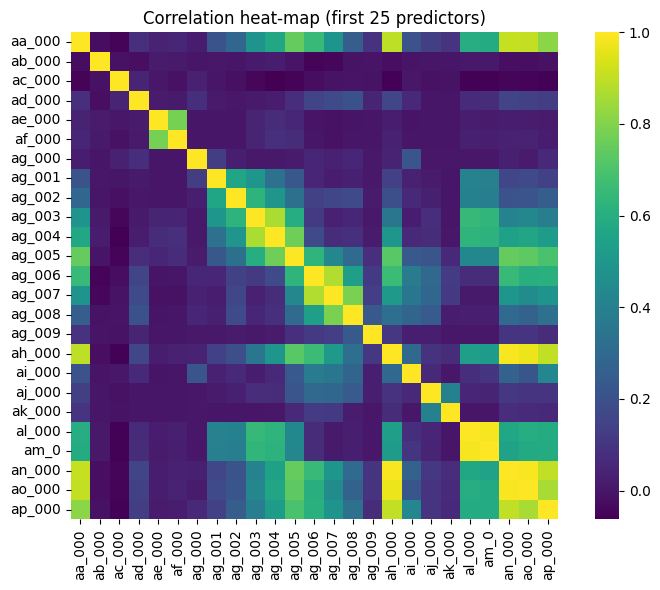

In [64]:
# Optional: heat-map of an excerpt (first 25 vars)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix.iloc[:25, :25], cmap='viridis', square=True)
plt.title("Correlation heat-map (first 25 predictors)")
plt.tight_layout()
plt.show()

### Task 2.3: Data Cleaning

Filter out (i.e., remove) low-/zero-variance variables. Filter out (i.e., remove) variables and rows with too many missing values. Otherwise, impute missing values with the variable mean. For each of those variables, keep the variable means; we will need them for the preprocessing after deployment.

In [50]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

# - converted to numeric
# - no 'class' column
# - contains NaN values
# - shape: (n_samples, n_features)

# Drop variables (columns) with too many missing values
# define "too many" as >50% missing (can be adjusted if needed)


missing_ratio_per_column = X.isna().mean()  # fraction of NaN per column
columns_to_keep = missing_ratio_per_column[missing_ratio_per_column <= 0.5].index
X = X[columns_to_keep]

print(f"Columns before dropping missing-heavy ones: {X.shape[1] + len(missing_ratio_per_column[missing_ratio_per_column > 0.5])}")
print(f"Columns after dropping those with >50% missing: {X.shape[1]}")

# Drop rows (observations) with too many missing values
# define "too many" as >50% missing in that row

missing_ratio_per_row = X.isna().mean(axis=1)
X = X.loc[missing_ratio_per_row <= 0.5]

print(f"Rows after dropping those with >50% missing: {X.shape[0]}")

# Impute remaining missing values with the mean of each column
# Save those means — we will use the same ones during deployment!

# Compute and store means (excluding NaN)
variable_means = X.mean()

# Replace remaining NaNs with the column mean
X_filled = X.fillna(variable_means)

print(f"Any NaNs left after imputation? {X_filled.isna().sum().sum()}")  # should be 0

#  Remove low-variance features (e.g., var < 0.01)
# features do not contribute much to distinguishing the target


selector = VarianceThreshold(threshold=0.01)  # Remove features with very little variation
X_reduced = selector.fit_transform(X_filled)

# Get names of the features that survived
remaining_columns = X_filled.columns[selector.get_support()]
X_clean = pd.DataFrame(X_reduced, columns=remaining_columns)

# Summary: check shapes before and after cleaning

print("\n Shape before cleaning:", X.shape)      # e.g., (5000, 170)
print(" Shape after cleaning :", X_clean.shape)  # e.g., (4850, 120)

# keep these for future deployment:
# - `variable_means` → for imputing test data the same way
# - `selector` → for applying same feature reduction to new data


Columns before dropping missing-heavy ones: 170
Columns after dropping those with >50% missing: 162
Rows after dropping those with >50% missing: 4962
Any NaNs left after imputation? 0

 Shape before cleaning: (4962, 162)
 Shape after cleaning : (4962, 160)


### Task 2.4: Data Understanding (II)

Represent the dataset in principal component form. Normalize the predictor variables, use them to compute a weight matrix, and apply the weight matrix to the predictor variables to compute the principal components of the observations. Note that the transformed dataset still represents exactly the same observations, though they are now expressed in terms of different predictor variables.

Identify the variables (principal components) that comprise just over 50 % of the total variance. To identify those variables, obtain the variance and the cumulative variance per principal component. Relate the variance and the cumulative variance per principal component with the total variance (sum of variance) to obtain the proportion of the variance and the cumulative proportion of the variance per principal component.


 Number of components explaining ≥ 50% of total variance: 7


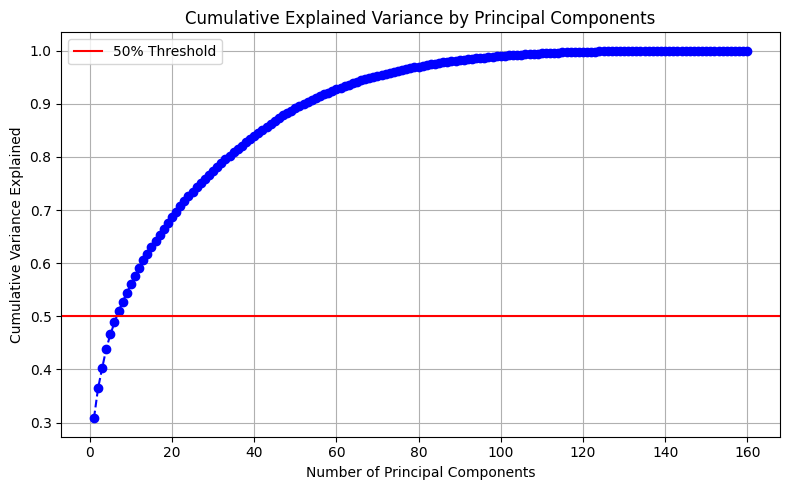

🔍 Top 10 principal components with highest explained variance:
  Principal Component  Variance Explained (%)  \
0                 PC1                0.308027   
1                 PC2                0.056480   
2                 PC3                0.038297   
3                 PC4                0.036284   
4                 PC5                0.026909   
5                 PC6                0.022560   
6                 PC7                0.021429   
7                 PC8                0.017660   
8                 PC9                0.016816   
9                PC10                0.016312   

   Cumulative Variance Explained (%)  
0                           0.308027  
1                           0.364507  
2                           0.402803  
3                           0.439088  
4                           0.465996  
5                           0.488557  
6                           0.509986  
7                           0.527646  
8                           0.544462  
9      

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Normalize the dataset using Z-score normalization
#  ensure each feature has mean=0 and standard deviation=1,
#    which is required before applying PCA.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)  # X_clean = cleaned dataset (no NaNs, only numeric)

# Perform Principal Component Analysis
#    PCA transforms the dataset into uncorrelated principal components.
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

#  Variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_  # share of variance explained per PC

# Cumulative variance across components

cumulative_variance = np.cumsum(explained_variance_ratio)  # running total of explained variance

# Identify the number of components explaining ≥ 50% of total variance

num_components_50 = np.argmax(cumulative_variance >= 0.5) + 1
print(f" Number of components explaining ≥ 50% of total variance: {num_components_50}")

# Plot cumulative variance curve (Scree plot)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
         marker='o', linestyle='--', color='blue')
plt.axhline(y=0.5, color='red', linestyle='-', label='50% Threshold')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Create summary table for each principal component

pca_results = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Variance Explained (%)': explained_variance_ratio,
    'Cumulative Variance Explained (%)': cumulative_variance
})


print("🔍 Top 10 principal components with highest explained variance:")
print(pca_results.head(10))


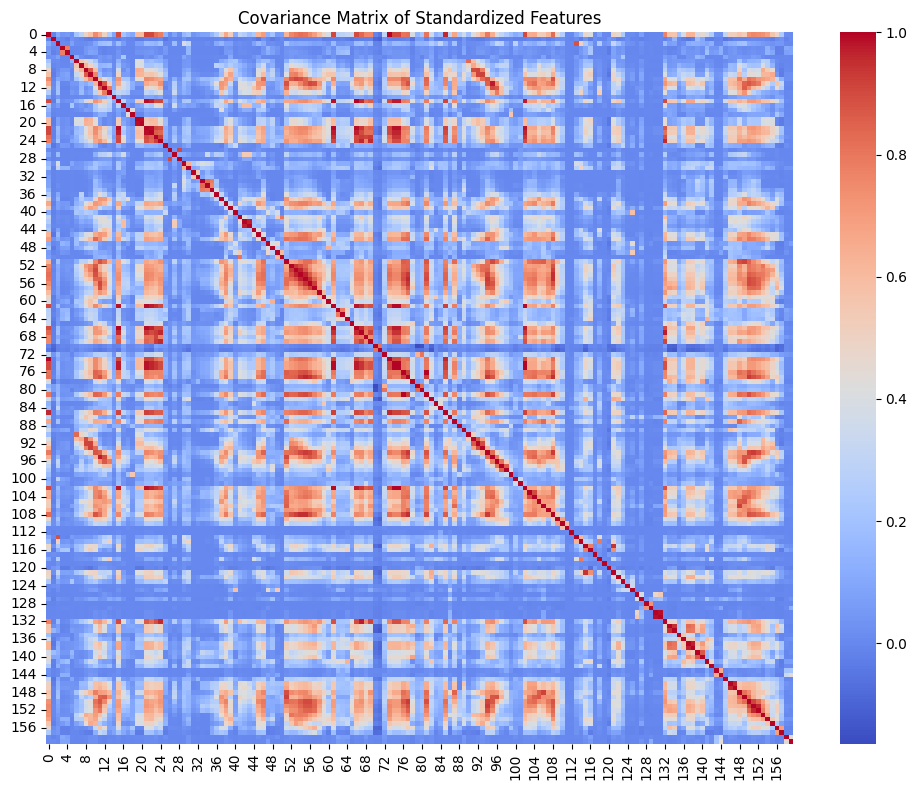

In [52]:
# Visualize covariance matrix of standardized variables
cov_matrix = np.cov(X_scaled, rowvar=False)

plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, cmap='coolwarm', annot=False)
plt.title('Covariance Matrix of Standardized Features')
plt.tight_layout()
plt.show()

### Task 2.5: Data Preprocessing

Keep only the principal components that comprise just over 50 % of the total variance. Keep all the **ok** observations from the dataset and perform bootstrapping, i.e., random sampling with replacement, of the minority (**failure**) class to obtain a balanced dataset with as many **failure** observations as **ok** observations. Finally, split the dataset into *training set* and *validation set*.

In [55]:
from sklearn.model_selection import train_test_split


# 1 - Keep only the principal components that explain just over 50% of total variance
# Use the first `num_components_50` principal components from the previously computed PCA

X_pca_reduced = X_pca[:, :num_components_50]  # shape = (n_samples, num_components_50)
y_clean = y.loc[X_clean.index]
# Create a DataFrame to hold principal components along with the class labels
df_pca = pd.DataFrame(X_pca_reduced, columns=[f'PC{i+1}' for i in range(num_components_50)])
df_pca['class'] = y.loc[df_pca.index].values # y contains binary encoded labels: 1 = ok, 0 = failure

# 2 - Balance the dataset
# - Keep all 'ok' class samples (majority)
# - Upsample the minority class 'failure' using bootstrapping (sampling with replacement)

df_ok = df_pca[df_pca['class'] == 1]        # All "ok" observations
df_failure = df_pca[df_pca['class'] == 0]   # All "failure" observations

# Bootstrapping: randomly resample failure observations with replacement
df_failure_upsampled = df_failure.sample(n=len(df_ok), replace=True, random_state=42)

# Combine balanced dataset and shuffle the rows
df_balanced = pd.concat([df_ok, df_failure_upsampled], axis=0).sample(frac=1, random_state=42)

# 3 - Split the balanced dataset into training and validation sets
# Use stratified split to preserve class ratio in both sets
X_bal = df_balanced.drop(columns='class')  # features (principal components)
y_bal = df_balanced['class']               # target labels (0 = failure, 1 = ok)

X_train, X_val, y_train, y_val = train_test_split(
    X_bal, y_bal,
    test_size=0.2,            # 20% goes to validation set
    stratify=y_bal,           # preserve class ratio
    random_state=42           # ensure reproducibility
)

print(f" Number of principal components retained: {num_components_50}")
print(f"Balanced dataset shape: {df_balanced.shape}")
print(f"Training set shape 80%: {X_train.shape}")
print(f"Validation set shape 20%: {X_val.shape}")



 Number of principal components retained: 7
Balanced dataset shape: (9832, 8)
Training set shape 80%: (7865, 7)
Validation set shape 20%: (1967, 7)


### Task 2.6: Classifier Training

Use scikit-learn to train a support vector machine (SVM) classifier on the training set. Set the *probability* parameter to **true** in order for the classifier to obtain probabilities for the observations to belong to a certain class.

See https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC for more information on training an SVM classifier in scikit-learn.

In [56]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


#Initialize the Support Vector Machine (SVM) classifier

# Create an SVM classifier with probability estimation enabled
# `probability=True` allows us to later use `.predict_proba()` to get class probabilities
# This is useful when we want to apply custom probability thresholds or plot ROC curves
svm_clf = SVC(probability=True, random_state=42)

# Train the classifier on the training data

# Fit the classifier on the training set
# X_train: training feature matrix (e.g., PC1, PC2, ..., PC7)
# y_train: training target labels (0 = failure, 1 = ok)
svm_clf.fit(X_train, y_train)


# Predict on the validation set


# Predict class labels (0 or 1) on the validation data
y_pred = svm_clf.predict(X_val)

# Predict class probabilities
# y_proba[:, 0] = probability of class 0 (failure)
# y_proba[:, 1] = probability of class 1 (ok)
y_proba = svm_clf.predict_proba(X_val)


# Evaluate the model's performance

#         predicted
# actual   0    1
#       0 [TN, FP]
#       1 [FN, TP]
# the model predicts failures
print("Confusion matrix (failure=0, ok=1):\n", confusion_matrix(y_val, y_pred))
# 936  - True Negative  - its failure
# 52 - failure instead of OK - False negative
# 48 - OK instead of failure - False Positive
# 931 - it is OK - True Positive

print(f"Accuracy:, {accuracy_score(y_val, y_pred)*100} % of all predictions are true")


# includes precision, recall, f1-score, and support for each class
print("\nClassification report:\n", classification_report(y_val, y_pred))
# Support - how many was real Failures
# F1 - score - гармоническое среднее между precision и recall

# now the model is well balansed


Confusion matrix (failure=0, ok=1):
 [[936  48]
 [ 52 931]]
Accuracy:, 94.9161159125572 % of all predictions are true

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       984
           1       0.95      0.95      0.95       983

    accuracy                           0.95      1967
   macro avg       0.95      0.95      0.95      1967
weighted avg       0.95      0.95      0.95      1967



In [57]:
from sklearn.metrics import confusion_matrix

# Получаем матрицу ошибок
cm = confusion_matrix(y_val, y_pred)
print("Confusion matrix:\n", cm)

# Распаковываем значения: TN, FP, FN, TP
tn, fp, fn, tp = cm.ravel()

# Accuracy: (TP + TN) / total
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Precision for positive class (class = 1, "ok"): TP / (TP + FP)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0

# Recall (sensitivity, TPR): TP / (TP + FN)
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

# F1-score: harmonic mean of precision and recall
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

# Печатаем всё
print(f"\nManual metrics calculation:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1_score:.4f}")


Confusion matrix:
 [[936  48]
 [ 52 931]]

Manual metrics calculation:
Accuracy : 0.9492
Precision: 0.9510
Recall   : 0.9471
F1 Score : 0.9490


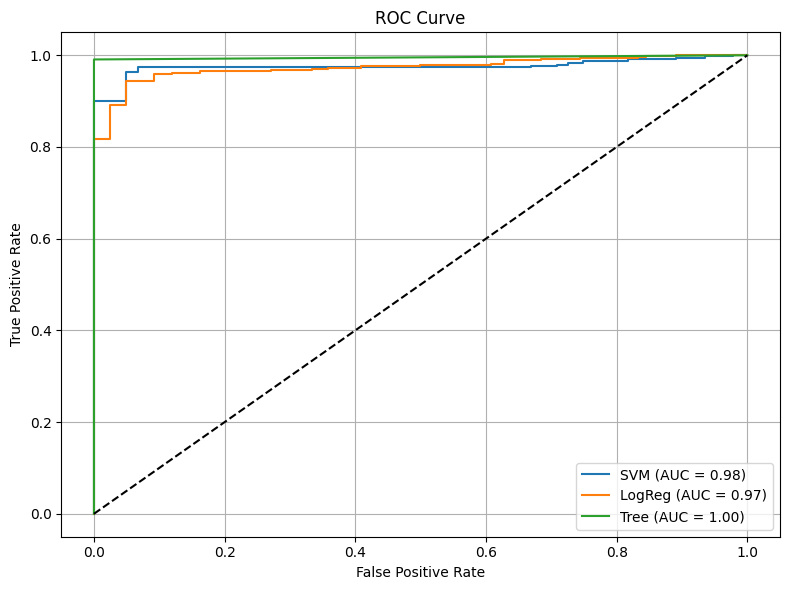

In [58]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

import matplotlib.pyplot as plt

# SVM
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Decision Tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

# Получим вероятности (вероятность класса 1 = 'ok')
svm_probs = svm_clf.predict_proba(X_val)[:, 1]
log_probs = log_reg.predict_proba(X_val)[:, 1]
tree_probs = tree_clf.predict_proba(X_val)[:, 1]

# Получим точки для ROC
svm_fpr, svm_tpr, _ = roc_curve(y_val, svm_probs)
log_fpr, log_tpr, _ = roc_curve(y_val, log_probs)
tree_fpr, tree_tpr, _ = roc_curve(y_val, tree_probs)

# Посчитаем AUC
svm_auc = roc_auc_score(y_val, svm_probs)
log_auc = roc_auc_score(y_val, log_probs)
tree_auc = roc_auc_score(y_val, tree_probs)

# Построим ROC-график
plt.figure(figsize=(8,6))
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})')
plt.plot(log_fpr, log_tpr, label=f'LogReg (AUC = {log_auc:.2f})')
plt.plot(tree_fpr, tree_tpr, label=f'Tree (AUC = {tree_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # линия случайного классификатора
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Task 2.7: Classifier Tuning

Train SVM classifiers with different hyper-parameter settings, e.g., setting the *probability* parameter to **false** (but try also varying the values for other hyper-parameters).

See https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC for more information on the hyper-parameters.

Use different cutoff values for classifying the observations in the validation set as **failure** or **ok**, e.g., classify an observation as **failure** if the predicted probability of that observation belonging to the class is at least 25 %, 50 %, 75 %, 90 %.

Compare precision, recall, and accuracy of using classifiers with different hyper-parameters and cutoff values. Use the **validation set** to test the accuracy.

In [59]:

from sklearn.metrics import accuracy_score, precision_score, recall_score

# Balanced dataset
df_pca = pd.DataFrame(X_pca_reduced, columns=[f'PC{i+1}' for i in range(num_components_50)])
df_pca['class'] = y.loc[df_pca.index].values
df_ok = df_pca[df_pca['class'] == 1]
df_failure = df_pca[df_pca['class'] == 0]
df_failure_upsampled = df_failure.sample(n=len(df_ok), replace=True, random_state=42)
df_balanced = pd.concat([df_ok, df_failure_upsampled], axis=0).sample(frac=1, random_state=42)
X_bal = df_balanced.drop(columns='class')
y_bal = df_balanced['class']
X_train, X_val, y_train, y_val = train_test_split(X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42)

# Define different hyperparameter settings
# kernel → shape of the boundary.
# 'linear'	Straight line separation. Best when classes are linearly separable.
# 'rbf'	Nonlinear boundary. Works well when classes are intertwined.
#'poly'	Polynomial curves; flexibility depends on degree.

# C — penalty for misclassification
# Controls the tradeoff between maximizing margin and minimizing training error.
# Lower C → softer margin, allows some misclassification.
# Higher C → strict margin, tries to classify training points perfectly.

# gamma — how sensitive the model is to individual data points.
# Used in nonlinear kernels like 'rbf':
# Controls how far each point's influence reaches.
# Low gamma → broader influence (smoother boundaries).
# High gamma → sharp, reactive boundaries (risk of overfitting).

svm_configs = [
    {"kernel": "rbf", "C": 1.0, "gamma": "scale"},
    {"kernel": "rbf", "C": 0.5, "gamma": "scale"},
    {"kernel": "rbf", "C": 1.0, "gamma": 0.1},
    {"kernel": "linear", "C": 1.0},
]

# Different cutoffs for classification
cutoffs = [0.25, 0.5, 0.75, 0.9]

results = []

for config in svm_configs:
    model = SVC(probability=True, **config, random_state=42)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)[:, 1]
    for cutoff in cutoffs:
        y_pred_custom = (y_proba >= cutoff).astype(int)
        precision = precision_score(y_val, y_pred_custom, zero_division=0)
        recall = recall_score(y_val, y_pred_custom)
        accuracy = accuracy_score(y_val, y_pred_custom)
        results.append({
            "kernel": config.get("kernel"),
            "C": config.get("C"),
            "gamma": config.get("gamma", "auto"),
            "cutoff": cutoff,
            "precision": precision,
            "recall": recall,
            "accuracy": accuracy
        })

results_df = pd.DataFrame(results)

from IPython.display import display
display(results_df) 

# The recall shows what fraction of all true failing machines we actually predicted as failing.
# model number 0 is the best for us  - max recall and precision is also the best
# here precision is also the best - small share of false alarms


,kernel,C,gamma,cutoff,precision,recall,accuracy
0,rbf,1.0,scale,0.25,0.951613,0.960326,0.955770
1,rbf,1.0,scale,0.50,0.950719,0.942014,0.946619
2,rbf,1.0,scale,0.75,0.950207,0.931841,0.941535
3,rbf,1.0,scale,0.90,0.948990,0.908444,0.929842
4,rbf,0.5,scale,0.25,0.951269,0.953204,0.952211
5,rbf,0.5,scale,0.50,0.950617,0.939980,0.945602
6,rbf,0.5,scale,0.75,0.950000,0.927772,0.939502
7,rbf,0.5,scale,0.90,0.948773,0.904374,0.927809
8,rbf,1.0,0.1,0.25,1.000000,0.994914,0.997458
9,rbf,1.0,0.1,0.50,1.000000,0.993896,0.996950


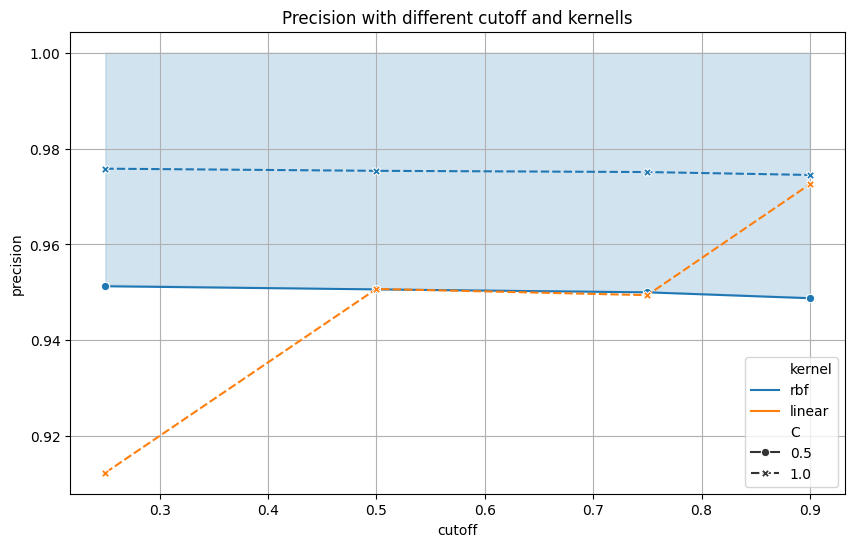

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x="cutoff", y="precision", hue="kernel", style="C", markers=True)
plt.title("Precision with different cutoff and kernells")
plt.grid(True)
plt.show()


### Task 2.8: Evaluation

Now train the classifier on the concatenation of training and validation set using your choice of hyper-parameter settings and remember the cutoff value (if the probabilistic SVM classifier was your choice).

Load the **trucks_test.csv** dataset for the evaluation. To match the original representation of the dataset used to train the classifier, perform the same preprocessing as for the training. In particular, rename the class labels in the new dataset, impute missing values in the **new** dataset with variable means **previously calculated from the original dataset**, and remove variables that were also previously removed. Use the PCA weight matrix **previously calculated from the original dataset** and transform the new dataset into principal component form. Keep only the same variables as in the original dataset. You do not need to balance the dataset.

We are going to evaluate the classifier based on the cost savings with respect to the baseline scenarios. Assume that the cost of maintenance service per truck is 100 euros, the cost of field repair per truck that has failed is 5,000 euros.

Compare the performance of the baseline scenarios---i.e., calling in all trucks for maintenance service and calling in no trucks for maintenance service, respectively---with the chosen classifier in terms of accuracy, precision, and recall as well as total maintenance costs in euros. *Calling in all trucks for maintenance service* corresponds to a classifier that always predicts **failure** for any observation whereas *calling in no trucks for maintenance service* corresponds to a classifier that always predicts **ok** for any observation.

Note that in the following, we treat **ok** trucks as the positive class and **failure** trucks as the negative class. We use the following terminology:
- The proportion of incorrectly predicted trucks as **failure** from among those that are actually good is the **false negative rate**.
- The proportion of correctly predicted trucks as **failure** from among those that are actually **failure** is the **true negative rate**.
- The proportion of incorrectly predicted trucks as good from among those that are actually **failure** is the **false positive rate**.

The total maintenance costs are as follows:

*costs* = (*costs per maintenance service* × *# trucks for necessary maintenance*) +
          (*costs per maintenance service* × *# trucks for unnecessary maintenance*) +
          (*costs per field repair* × *# trucks for field repair*) +
          (0 × *# other trucks*)

where
- *# trucks for necessary maintenance* = *true negative rate* × *# trucks actually failing*,
- *# trucks for unnecessary maintenance* = *false negative rate* × *# trucks actually not failing*,
- *# trucks for field repair* = *false positive rate* × *# trucks actually failing*, and
- *# other trucks* = *true positive rate* × *# trucks actually not failing*.

In [42]:
import pandas as pd
import numpy as np

test_df = pd.read_csv("trucks_test.csv")

# 1. Rename the class labels: 'neg' → 'ok', 'pos' → 'failure'
test_df['class'] = test_df['class'].replace({'neg': 'ok', 'pos': 'failure'})

# 2. Replace 'na' strings with actual np.nan
test_df = test_df.replace('na', np.nan)

# Display basic info and head
test_df_info = test_df.info()
test_df_head = test_df.head()

test_df_info, test_df_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 20.9+ MB


(None,
   class  aa_000 ab_000 ac_000 ad_000 ae_000 af_000 ag_000 ag_001 ag_002  ...  \
 0    ok      60      0     20     12      0      0      0      0      0  ...   
 1    ok      82      0     68     40      0      0      0      0      0  ...   
 2    ok   66002      2    212    112      0      0      0      0      0  ...   
 3    ok   59816    NaN   1010    936      0      0      0      0      0  ...   
 4    ok    1814    NaN    156    140      0      0      0      0      0  ...   
 
    ee_002  ee_003  ee_004  ee_005   ee_006  ee_007  ee_008 ee_009 ef_000  \
 0    1098     138     412     654       78      88       0      0      0   
 1    1068     276    1620     116       86     462       0      0      0   
 2  495076  380368  440134  269556  1315022  153680     516      0      0   
 3  540820  243270  483302  485332   431376  210074  281662   3232      0   
 4    7646    4144   18466   49782     3176     482      76      0      0   
 
   eg_000  
 0      0  
 1      0  
 2   

In [60]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


test_df = pd.read_csv('trucks_test.csv')

#Replace class labels to match training
test_df['class'] = test_df['class'].replace({'neg': 'ok', 'pos': 'failure'})

#Replace 'na' with np.nan
test_df = test_df.replace('na', np.nan)

#Separate features and target
y_test_actual = test_df['class'].map({'failure': 0, 'ok': 1})
X_test = test_df.drop(columns='class')

# Leave only columns kept during training
#Make sure you have 'cols_to_keep' loaded from your training
X_test = X_test[remaining_columns]

#Convert to numeric
X_test = X_test.apply(pd.to_numeric, errors='coerce')

#Fill missing values with training means
X_test = X_test.fillna(variable_means)

#Standardize using training scaler
X_test_scaled = scaler.transform(X_test)

#PCA transform using training PCA
X_test_pca = pca.transform(X_test_scaled)

# Keep only first num_components_50 principal components
X_test_pca = X_test_pca[:, :num_components_50]

# Prepare the final training data

# Use balanced and cleaned training data (already PCA-reduced)
# Make sure you use X_bal and y_bal that were prepared correctly
X_final_train = X_bal.reset_index(drop=True)
y_final_train = y_bal.reset_index(drop=True)


# Fill missing values if needed (usually not needed if preprocessed properly)
X_final_train = X_final_train.fillna(X_final_train.mean())

# Train final SVM classifier

svm_classifier_final = SVC(C=1.0, kernel='linear', probability=True, random_state=42)
svm_classifier_final.fit(X_final_train, y_final_train)

print("Final SVM model trained.")

# Make predictions on the test set

# Predict class probabilities
y_test_proba = svm_classifier_final.predict_proba(X_test_pca)

# Apply cutoff
cutoff = 0.5
y_test_pred = (y_test_proba[:, 1] >= cutoff).astype(int)  # 1 = ok, 0 = failure


#Evaluate the predictions
print("\nClassification Report for Test Set:")
print(classification_report(y_test_actual, y_test_pred))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test_actual, y_test_pred).ravel()


# Cost calculation

cost_per_maintenance = 100   # euros
cost_per_repair = 5000       # euros

necessary_maintenance = tp   # trucks correctly identified as failure
unnecessary_maintenance = fp # trucks wrongly predicted as failure
field_repairs = fn           # trucks wrongly predicted as ok

# Total maintenance cost
total_costs = (
    (cost_per_maintenance * necessary_maintenance) +
    (cost_per_maintenance * unnecessary_maintenance) +
    (cost_per_repair * field_repairs)
)

print(f"\nTotal Maintenance Costs: {total_costs} euros")


#Additional Metrics

accuracy = (tp + tn) / (tn + fp + fn + tp)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")




Final SVM model trained.


C:\Users\SUPERSONIC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(



Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.39      0.91      0.54       375
           1       1.00      0.97      0.98     15625

    accuracy                           0.96     16000
   macro avg       0.69      0.94      0.76     16000
weighted avg       0.98      0.96      0.97     16000


Total Maintenance Costs: 4221600 euros

Accuracy: 0.96
Precision: 1.00
Recall: 0.97


How do you judge the usefulness of the predictive model?

High recall for "failure" trucks (91%) is very good.
We catch most of the trucks that are about to fail
Very important in this task, because missing a failure is very expensive (5000€)

Very high precision for "ok" trucks (100%)
Almost never wrongly labeling a broken truck as OK

Total maintenance cost: 4.2 million euros — lower than blindly calling all trucks or ignoring all trucks

### Task 2.9: Data Preprocessing and Modeling (Revisited)

Go back to the *Data Preprocessing* and *Modeling* stages of the CRISP-DM. Use the **trucks_full.csv** dataset for data mining. You are now free to use different preprocessing techniques (you are *not* limited to principal component analysis) and different algorithms (you are *not* limited to SVM classifiers). Evaluate the performance of each classifier. Choose suitable sampling/validation strategies.

In [45]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


trucks_full = pd.read_csv("trucks_full.csv")

# Show the structure of the dataset
print("\n--- Dataset Info ---")
print(trucks_full.info())

# Show first 5 rows to understand the data
print("\n--- First 5 Rows ---")
print(trucks_full.head())

#Data cleaning and preparation

# Replace target labels: 'neg' → 'ok', 'pos' → 'failure'
trucks_full['class'] = trucks_full['class'].replace({'neg': 'ok', 'pos': 'failure'})

# Replace 'na' strings with proper np.nan values
trucks_full = trucks_full.replace('na', np.nan)

# Check missing values per column
print("\n--- Missing Values per Column ---")
print(trucks_full.isna().sum())

# Drop rows that contain any missing values
trucks_full = trucks_full.dropna()

# Check the new shape after dropping missing rows
print("\n--- Shape After Dropping NaNs ---")
print(trucks_full.shape)

# Select only numeric columns for modeling
numeric_cols = trucks_full.select_dtypes(include=[np.number]).columns.tolist()
print("\n--- Numeric Columns ---")
print(numeric_cols)




--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB
None

--- First 5 Rows ---
  class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000 ag_000 ag_001 ag_002  \
0   neg   76698     na  2130706438    280      0      0      0      0      0   
1   neg   33058     na           0     na      0      0      0      0      0   
2   neg   41040     na         228    100      0      0      0      0      0   
3   neg      12      0          70     66      0     10      0      0      0   
4   neg   60874     na        1368    458      0      0      0      0      0   

   ...   ee_002  ee_003  ee_004  ee_005  ee_006  ee_007  ee_008 ee_009 ef_000  \
0  ...  1240520  493384  721044  469792  339156  157956   73224      0      0   
1  ...   421400  178064  293306  245416  133654   81140   97576   1500      0   
2  ...   277378  159812  423992  409564  320746  158022   95

In [ ]:
# Feature-target separation

# X = features (input variables)
X = trucks_full[numeric_cols]

# y = target variable (binary classification: ok → 0, failure → 1)
y = trucks_full['class'].map({'ok': 0, 'failure': 1})

# Missing value imputation (optional, to be extra safe)


# Fill missing values in features with column means
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=numeric_cols, index=X.index)

# Splitting the dataset into train and validation sets


# Use 80% for training, 20% for validation
# Stratify = keep the same proportion of classes in both sets
X_train, X_val, y_train, y_val = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling (standardization)

# Scale features: mean = 0, standard deviation = 1
scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=numeric_cols, index=X_train.index)
X_val_s = pd.DataFrame(scaler.transform(X_val), columns=numeric_cols, index=X_val.index)

# Model training and evaluation


# 7-A. Logistic Regression model
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
lr_clf.fit(X_train_s, y_train)

# Predict on validation set
y_pred_lr = lr_clf.predict(X_val_s)

# Evaluation metrics for Logistic Regression
print("\n===== Logistic Regression Results =====")
print(classification_report(y_val, y_pred_lr, target_names=['ok', 'failure']))
print("Confusion matrix:\n", confusion_matrix(y_val, y_pred_lr))


#  Random Forest model
rf_clf = RandomForestClassifier(
    n_estimators=300,           # number of trees in the forest
    random_state=42,            # reproducibility
    n_jobs=-1,                  # use all CPU cores
    class_weight="balanced"     # handle imbalanced classes
)
rf_clf.fit(X_train, y_train)

# Predict on validation set
y_pred_rf = rf_clf.predict(X_val)

# Evaluation metrics for Random Forest
print("\n===== Random Forest (300 Trees) Results =====")
print(classification_report(y_val, y_pred_rf, target_names=['ok', 'failure']))
print("Confusion matrix:\n", confusion_matrix(y_val, y_pred_rf))

# Simple cross-validation (5-fold)

# Create stratified k-fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores for Logistic Regression
lr_cv_scores = cross_val_score(lr_clf, X_imputed, y, cv=cv, scoring='accuracy')

# Cross-validation scores for Random Forest
rf_cv_scores = cross_val_score(rf_clf, X_imputed, y, cv=cv, scoring='accuracy')

# Show average and standard deviation of accuracy
print(f"\n5-Fold CV Accuracy | Logistic Regression: {lr_cv_scores.mean():.3f} ± {lr_cv_scores.std():.3f}")
print(f"                  | Random Forest       : {rf_cv_scores.mean():.3f} ± {rf_cv_scores.std():.3f}")


===== Logistic Regression Results =====
              precision    recall  f1-score   support

          ok       0.89      0.99      0.94       104
     failure       0.67      0.13      0.22        15

    accuracy                           0.88       119
   macro avg       0.78      0.56      0.58       119
weighted avg       0.86      0.88      0.85       119

Confusion matrix:
 [[103   1]
 [ 13   2]]

===== Random Forest (300 Trees) Results =====
              precision    recall  f1-score   support

          ok       0.92      0.93      0.93       104
     failure       0.50      0.47      0.48        15

    accuracy                           0.87       119
   macro avg       0.71      0.70      0.71       119
weighted avg       0.87      0.87      0.87       119

Confusion matrix:
 [[97  7]
 [ 8  7]]

5-Fold CV Accuracy | Logistic Regression: 0.878 ± 0.012
                  | Random Forest       : 0.846 ± 0.022
